In [82]:
import torch
import torch.nn as nn
import os
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim import LBFGS
import matplotlib.pyplot as plt
import pandas as pd

In [83]:
def activation(name):
    if name in ['tanh', 'Tanh']:
        return nn.Tanh()
    elif name in ['relu', 'ReLU']:
        return nn.ReLU(inplace=True)
    elif name in ['lrelu', 'LReLU']:
        return nn.LeakyReLU(inplace=True)
    elif name in ['sigmoid', 'Sigmoid']:
        return nn.Sigmoid()
    elif name in ['softplus', 'Softplus']:
        return nn.Softplus(beta=4)
    elif name in ['celu', 'CeLU']:
        return nn.CELU()
    elif name in ['elu']:
        return nn.ELU()
    elif name in ['mish']:
        return nn.Mish()
    else:
        raise ValueError('Unknown activation function')

################################################################
#  1d fourier layer
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        # x.shape == [batch_size, in_channels, number of grid points]
        d = x.shape[2]
        # Compute Fourier coefficients
        x = torch.fft.rfft(x,dim=2)
        # Multiply Fourier modes
        x = self.compl_mul1d(x, self.weights1)
        # Return to physical space
        x = torch.fft.irfft(x, n=d)
        return x


####################################################################

class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 1  # pad the domain if input is non-periodic
        self.linear_p = nn.Linear(3, self.width)  # input channel is 2: (u0(x), x)

        self.spect1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.lin0 = nn.Conv1d(self.width, self.width, 1)
        self.lin1 = nn.Conv1d(self.width, self.width, 1)
        self.lin2 = nn.Conv1d(self.width, self.width, 1)

        self.linear_q = nn.Linear(self.width, 32)
        self.output_layer = nn.Linear(32, 1)

        self.activation = torch.nn.Tanh()

    def fourier_layer(self, x, spectral_layer, conv_layer):
       # return self.activation(spectral_layer(x))
        return self.activation(spectral_layer(x) + conv_layer(x))
        
                       
    def linear_layer(self, x, linear_transformation):
        return self.activation(linear_transformation(x))

    def forward(self, x):
        # grid = self.get_grid(x.shape, x.device)
        # x = torch.cat((x, grid), dim=-1)
        x = self.linear_p(x)
        x = x.permute(0, 2, 1)
        # x = F.pad(x, [0, self.padding])  # pad the domain if input is non-periodic

        x = self.fourier_layer(x, self.spect1, self.lin0)
        x = self.fourier_layer(x, self.spect2, self.lin1)
        x = self.fourier_layer(x, self.spect3, self.lin2)

        # x = x[..., :-self.padding]  # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)

        x = self.linear_layer(x, self.linear_q)
        x = self.output_layer(x)
        return x


In [84]:
class DatasetTask3(TensorDataset):
    # https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
    def __init__(self, tensor_data, window_len):
        self.tensor_data = tensor_data
        self.window_len = window_len    # size of input/output sequences

    def __len__(self):
        # gives number of input and output pairs
        return int(len(self.tensor_data)/self.window_len) - 1
    
    def __getitem__(self, idx):
        # idx is index of individual input-output pair
        lower_end = idx*self.window_len
        upper_end = (idx + 1)*self.window_len
        inputs = self.tensor_data[lower_end:upper_end]
        outputs = self.tensor_data[upper_end:upper_end+self.window_len,1:]
        
        return inputs, outputs

In [95]:
def normalize(x):
    """ mins and maxs for backconversion in lists"""
    t= x[:,0]; Tf= x[:,1] ; Ts = x[:,2]
    
    max_t , max_Tf, max_Ts = torch.max(t), torch.max(Tf), torch.max(Ts)
    min_t , min_Tf, min_Ts = torch.min(t), torch.min(Tf), torch.min(Ts)
    
    normalized_data = torch.zeros_like(x)
    normalized_data[:, 0] = (t - min_t)/(max_t - min_t)
    normalized_data[:, 1] = (Tf - min_Tf)/(max_Tf - min_Tf)
    normalized_data[:, 2] = (Ts - min_Ts)/(max_Ts - min_Ts)

    return normalized_data, [min_t , min_Tf, min_Ts], [max_t , max_Tf, max_Ts]

def denormalize(x, mins, maxs):
    t  = x[:,0]
    Tf = x[:,1]
    Ts = x[:,2]

    data = torch.zeros_like(x)
    data[:,0]= (maxs[0]-mins[0])*t +mins[0]
    data[:,1]= (maxs[1]-mins[1])*Tf +mins[1]
    data[:,2]= (maxs[2]-mins[2])*Ts +mins[2]
    return data

def regularization(model, order):
    reg_loss = 0
    for name, param in model.named_parameters():
        if 'weight' in name or 'bias' in name:
            reg_loss = reg_loss + torch.norm(param, order)
    return reg_loss

def fit(fno_f, fno_s,epochs, optimizer, training_set):  
       # history = list()
        l = torch.nn.MSELoss()
    
        for epoch in range(epochs):
            train_mse = 0.0
            for step, (input_batch, output_batch) in enumerate(training_set):
                
                optimizer.zero_grad()
                output_pred_batch = torch.cat([fno_f(input_batch),fno_s(input_batch)],dim=2).squeeze(2)
                loss = l(output_pred_batch, output_batch) 
                loss.backward()
                optimizer.step()
                #history_f.append(loss_f.item())
                train_mse += loss.item()
                
            train_mse /= len(training_set)
            scheduler.step()
        
            if epoch % freq_print == 0: 
                print("######### Epoch:", epoch, " ######### Train Loss:", train_mse)
                test_set = train_data[-window_len:,:].reshape(1,window_len,3)
                output = torch.cat([fno_f(test_set), fno_s(test_set)],dim=2).squeeze()

                input_meas = denormalize(train_data, mins, maxs)
                output[:,0] = (maxs[1]-mins[1])* output[:,0] + mins[1]
                output[:,1] = (maxs[2]-mins[2])* output[:,1] + mins[2]

                total_time = torch.cat([input_meas[:,0], test_time], 0)
                total_pred = torch.cat([input_meas[:,1:], output[:-1]], 0)

                plt.figure(figsize=(16,8))
                plt.plot(input_meas[2:,0].detach(), input_meas[2:,1].detach(),label='meas Tf')
                plt.plot(input_meas[2:,0].detach(), input_meas[2:,2].detach(),label='meas Ts')
                plt.plot(total_time[-window_len:].detach(), total_pred[-window_len:,0].detach(), label = 'pred Tf',color='green')
                plt.plot(total_time[-window_len:].detach(), total_pred[-window_len:,1].detach(), label = 'pred Ts',color='red')
                plt.grid('True')
                plt.legend()
                plt.show()
                
                

def plot_hist(hist):
    plt.figure()
    plt.grid(True, which="both", ls=":")
    plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
    plt.xscale("log")
    plt.legend()

######### Epoch: 0  ######### Train Loss: 0.1837385255843401


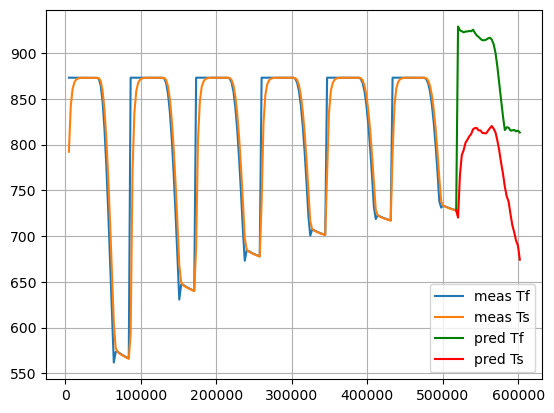

######### Epoch: 50  ######### Train Loss: 2.6809322093868106e-06


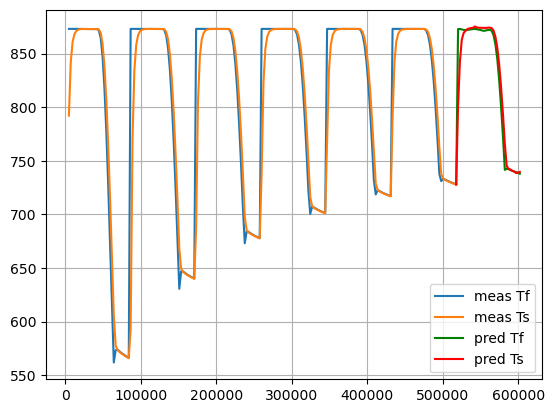

######### Epoch: 100  ######### Train Loss: 1.0785718018269109e-06


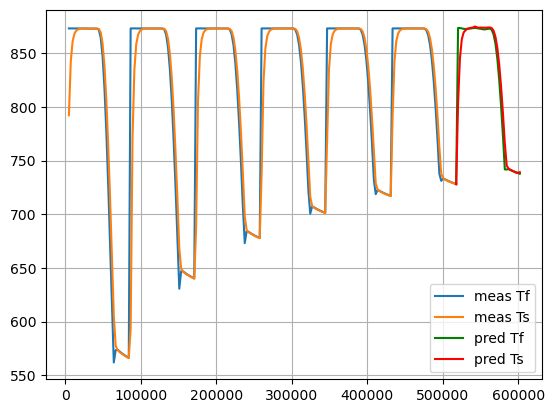

######### Epoch: 150  ######### Train Loss: 6.961886640510784e-07


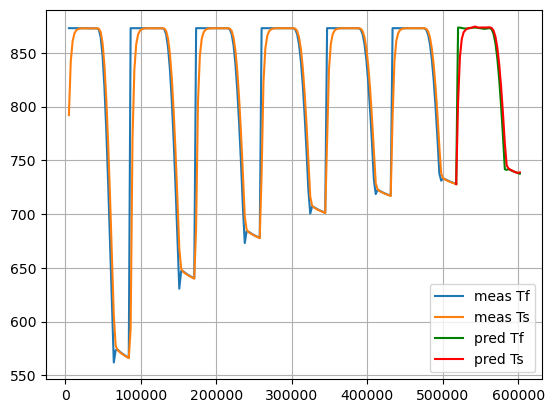

######### Epoch: 200  ######### Train Loss: 5.571813090909927e-07


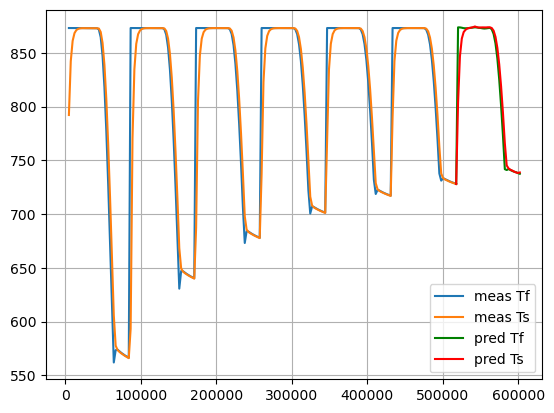

######### Epoch: 250  ######### Train Loss: 4.946414890127926e-07


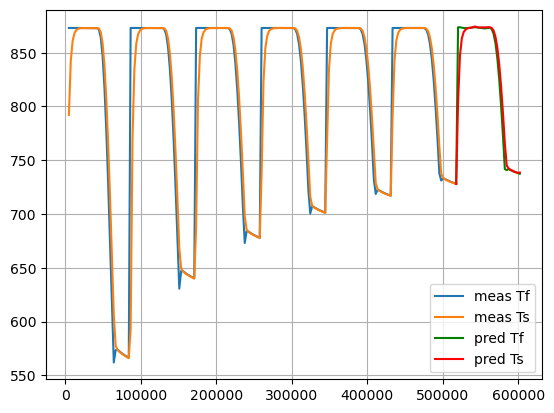

######### Epoch: 300  ######### Train Loss: 4.6326324820711307e-07


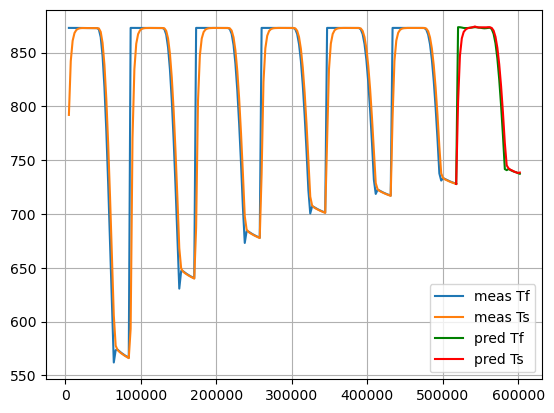

######### Epoch: 350  ######### Train Loss: 4.4660450555511487e-07


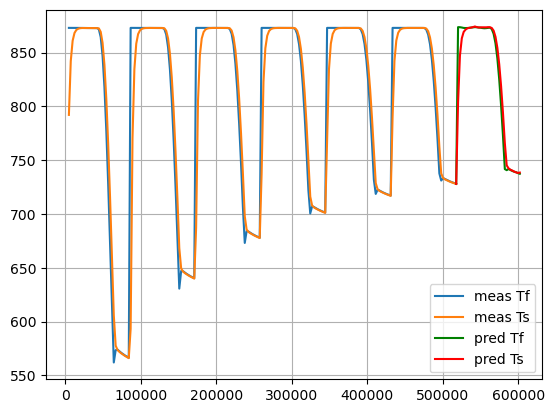

######### Epoch: 400  ######### Train Loss: 4.3750910663220564e-07


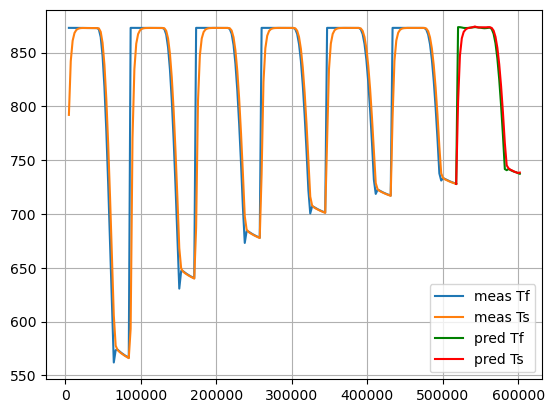

######### Epoch: 450  ######### Train Loss: 4.3248186329947205e-07


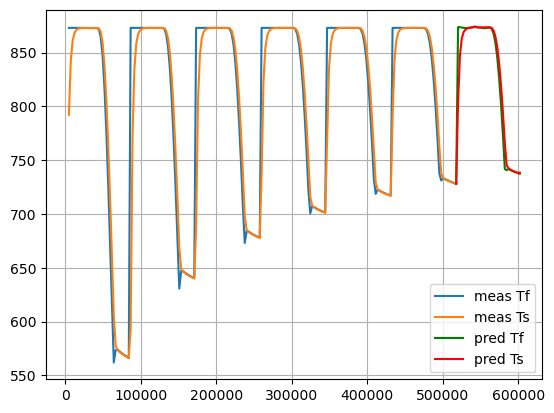

######### Epoch: 500  ######### Train Loss: 4.2967446063357783e-07


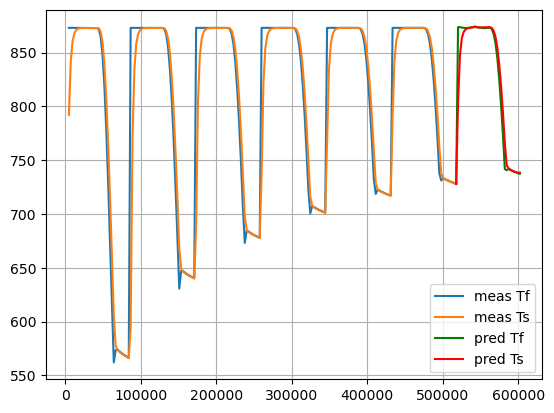

######### Epoch: 550  ######### Train Loss: 4.281103912262552e-07


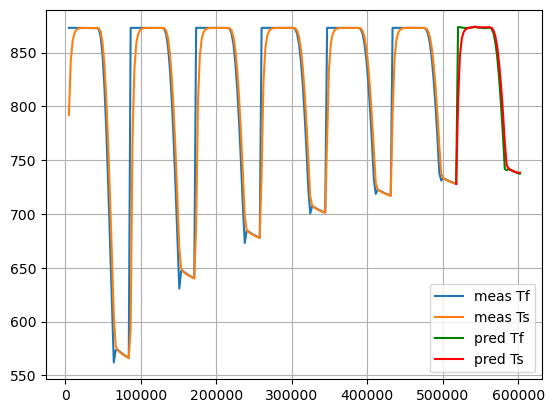

######### Epoch: 600  ######### Train Loss: 4.272418436812586e-07


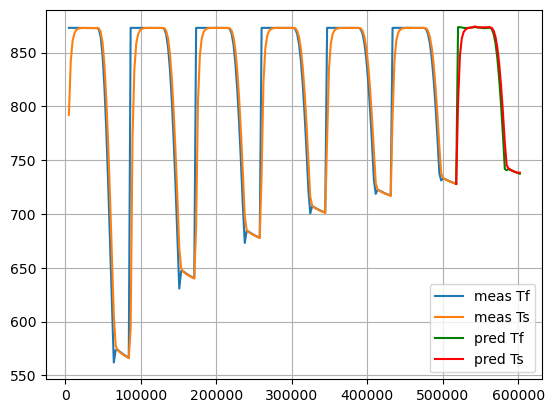

######### Epoch: 650  ######### Train Loss: 4.267546898972796e-07


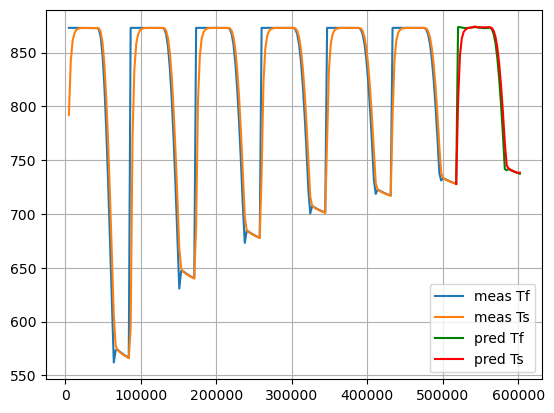

######### Epoch: 700  ######### Train Loss: 4.265096976041605e-07


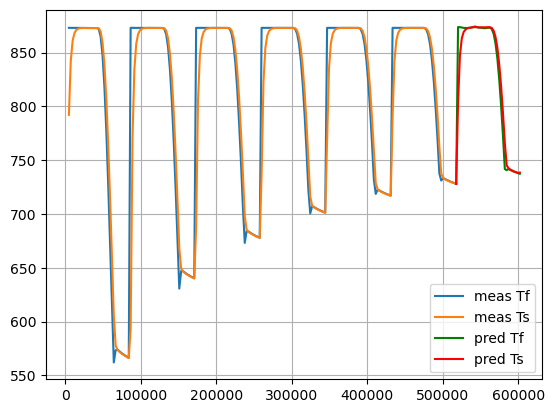

######### Epoch: 750  ######### Train Loss: 4.263874757270969e-07


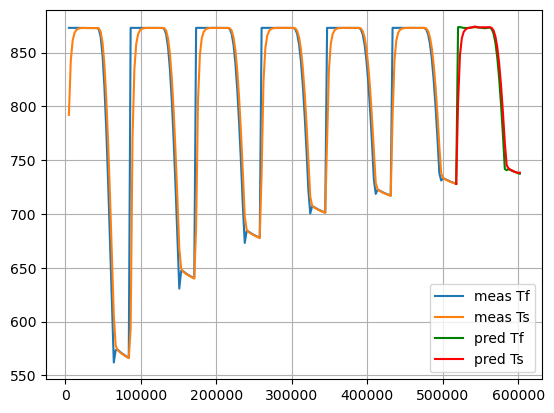

######### Epoch: 800  ######### Train Loss: 4.2632889005744803e-07


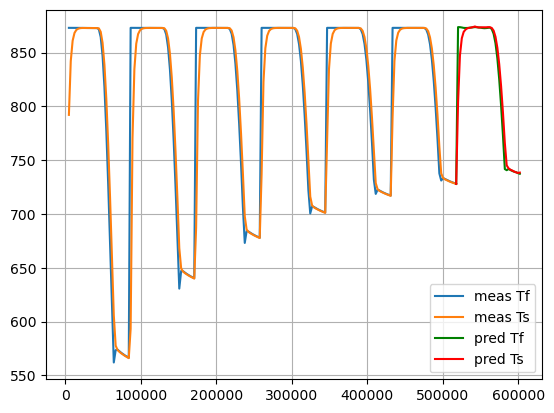

######### Epoch: 850  ######### Train Loss: 4.263114703917381e-07


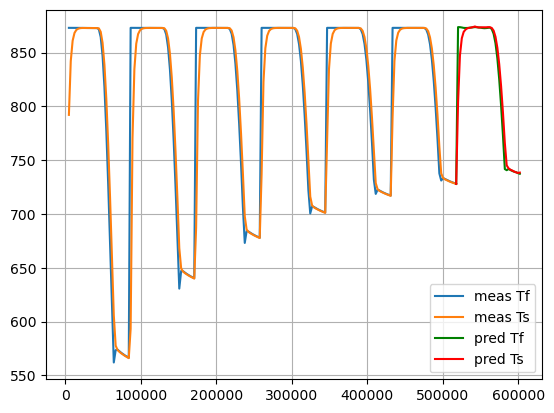

######### Epoch: 900  ######### Train Loss: 4.262998459125811e-07


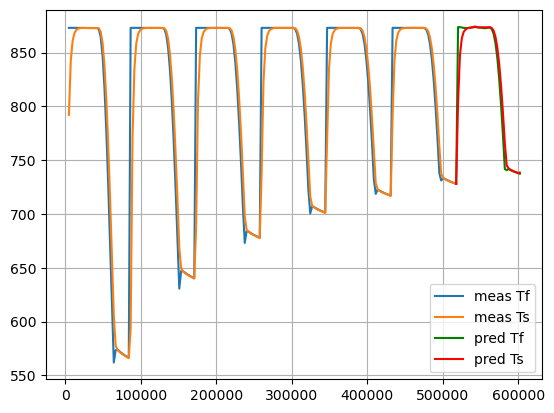

######### Epoch: 950  ######### Train Loss: 4.263010282556934e-07


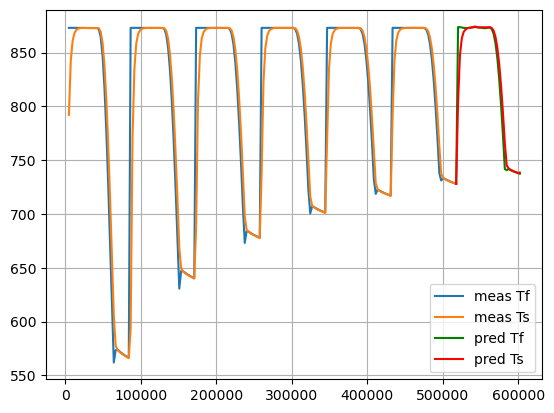

######### Epoch: 1000  ######### Train Loss: 4.2629684173789426e-07


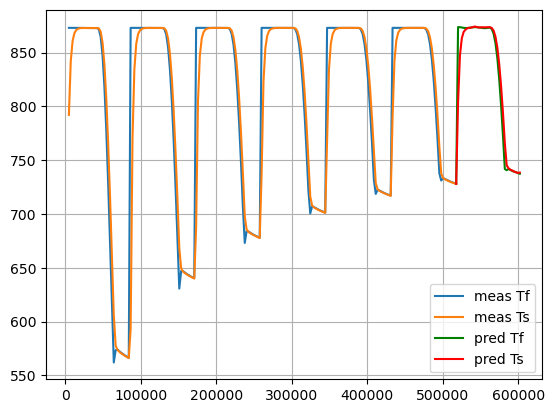

######### Epoch: 1050  ######### Train Loss: 4.263015625838307e-07


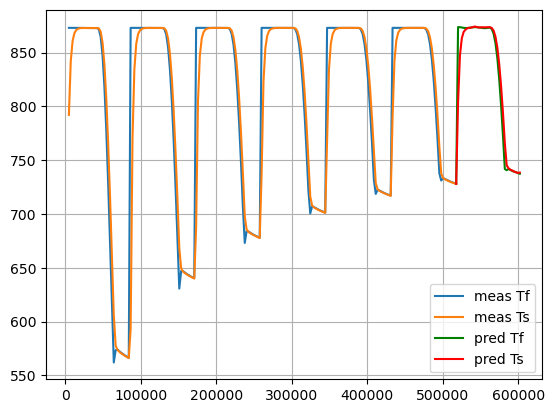

######### Epoch: 1100  ######### Train Loss: 4.2629524727999523e-07


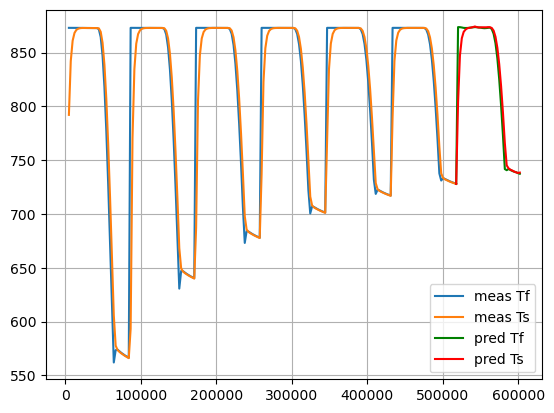

######### Epoch: 1150  ######### Train Loss: 4.2629213794498353e-07


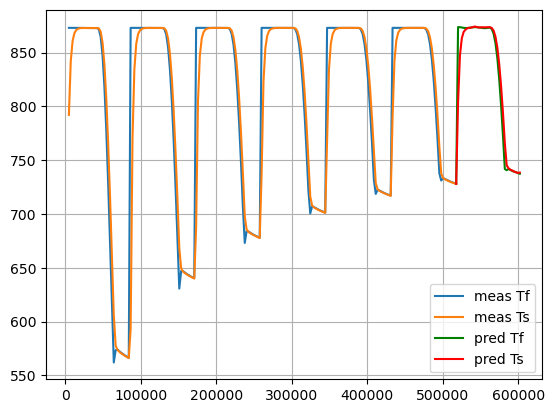

######### Epoch: 1200  ######### Train Loss: 4.262964040435691e-07


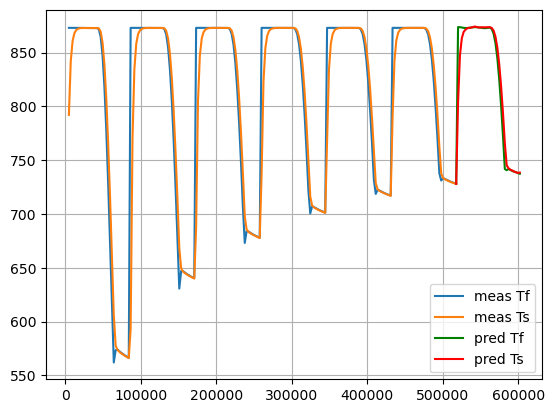

######### Epoch: 1250  ######### Train Loss: 4.262935220822328e-07


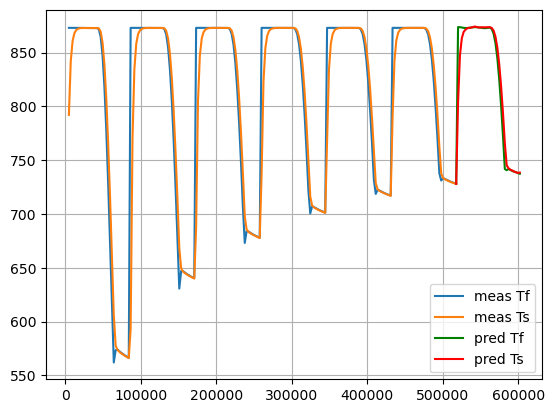

######### Epoch: 1300  ######### Train Loss: 4.2629341407973697e-07


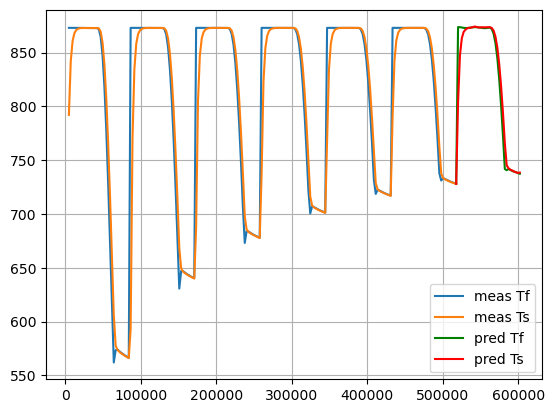

######### Epoch: 1350  ######### Train Loss: 4.262946305289006e-07


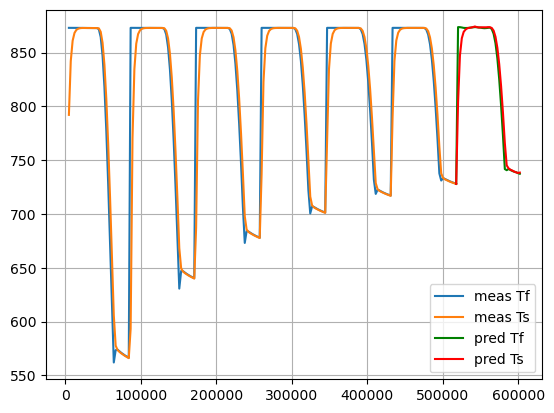

######### Epoch: 1400  ######### Train Loss: 4.262946305289006e-07


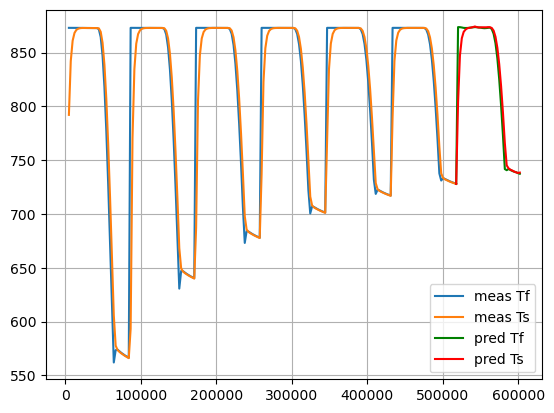

######### Epoch: 1450  ######### Train Loss: 4.262943178900969e-07


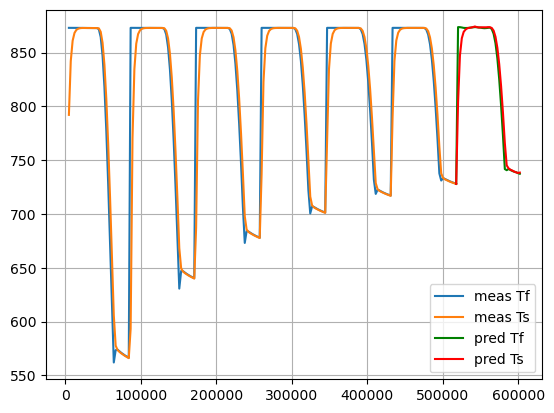

######### Epoch: 1500  ######### Train Loss: 4.262943178900969e-07


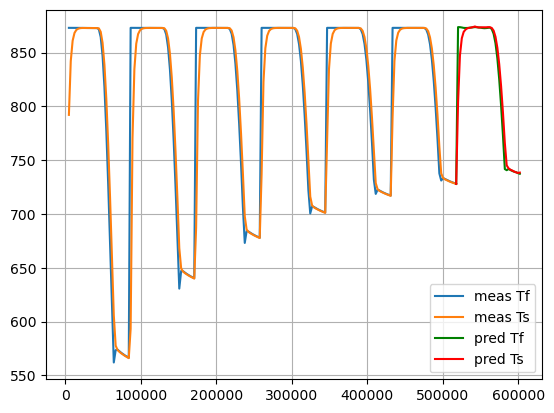

######### Epoch: 1550  ######### Train Loss: 4.262943178900969e-07


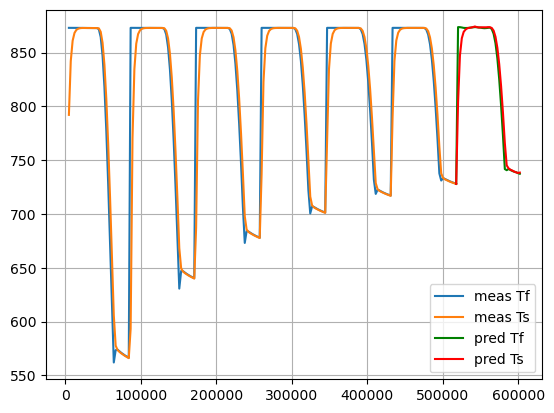

######### Epoch: 1600  ######### Train Loss: 4.262943178900969e-07


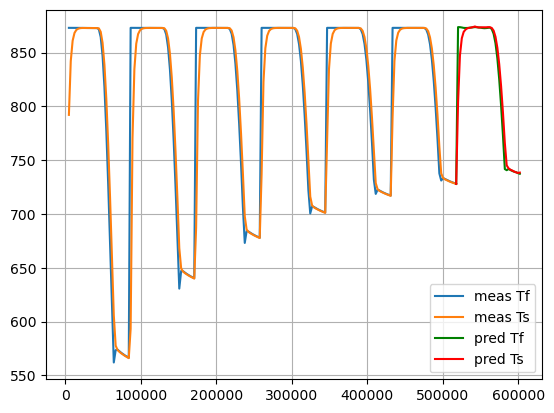

######### Epoch: 1650  ######### Train Loss: 4.262943178900969e-07


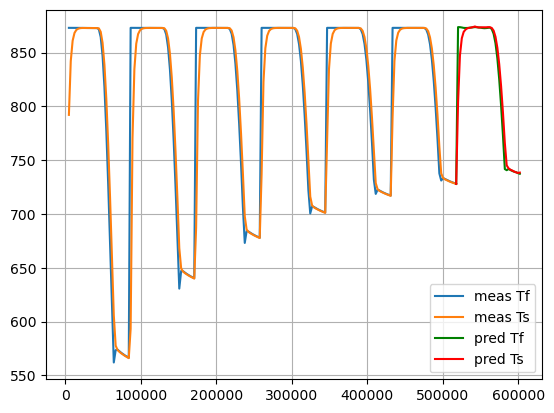

######### Epoch: 1700  ######### Train Loss: 4.262943178900969e-07


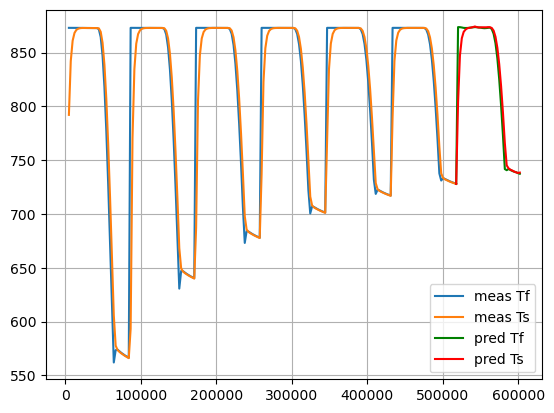

######### Epoch: 1750  ######### Train Loss: 4.262943178900969e-07


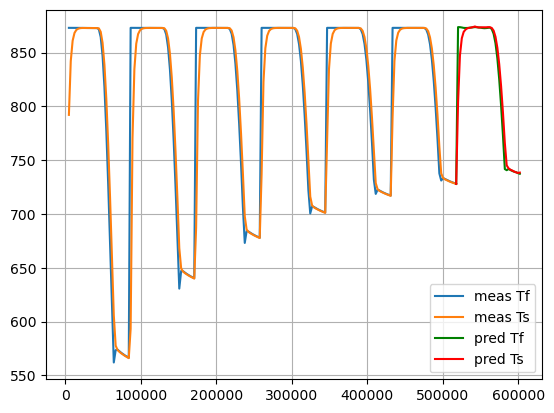

######### Epoch: 1800  ######### Train Loss: 4.262943178900969e-07


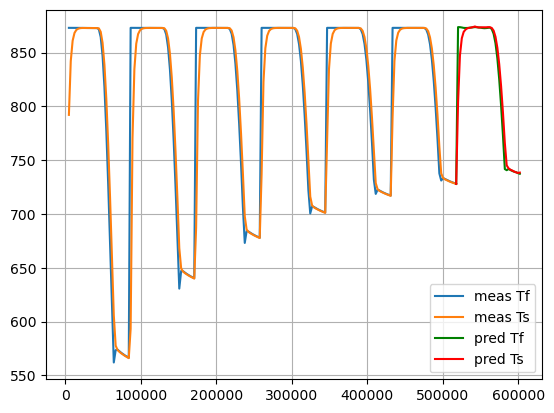

######### Epoch: 1850  ######### Train Loss: 4.262943178900969e-07


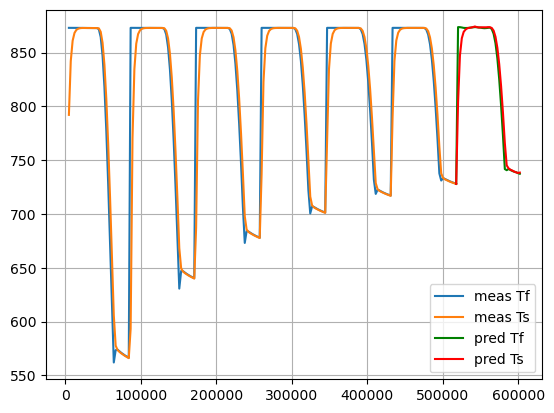

######### Epoch: 1900  ######### Train Loss: 4.262943178900969e-07


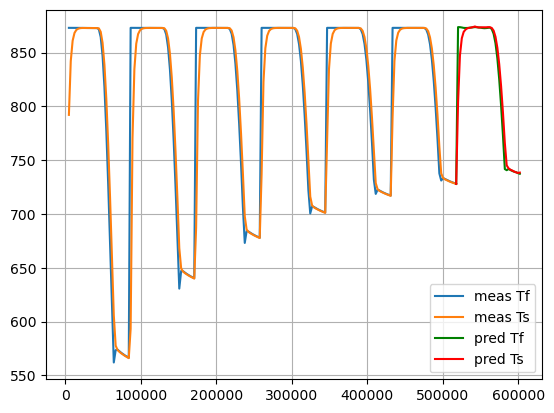

######### Epoch: 1950  ######### Train Loss: 4.262943178900969e-07


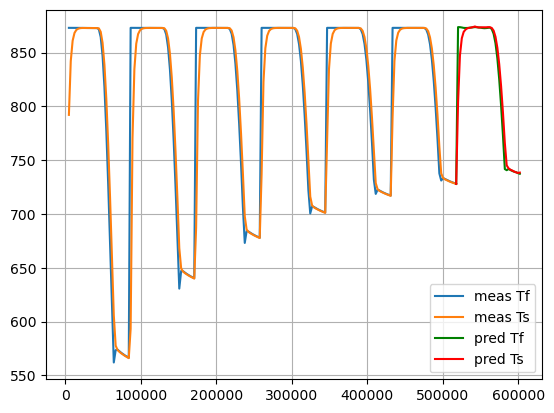

######### Epoch: 2000  ######### Train Loss: 4.262943178900969e-07


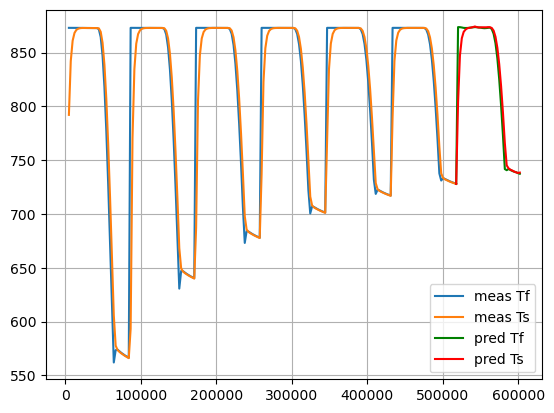

######### Epoch: 2050  ######### Train Loss: 4.262943178900969e-07


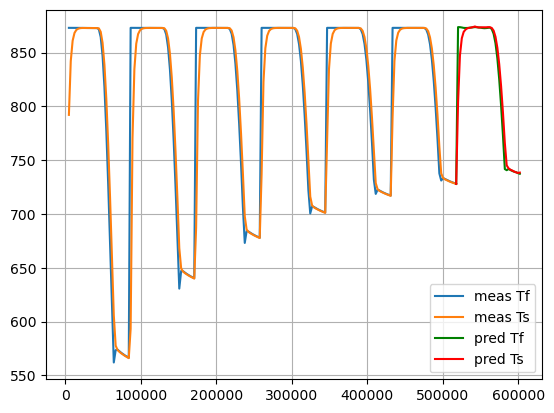

######### Epoch: 2100  ######### Train Loss: 4.262943178900969e-07


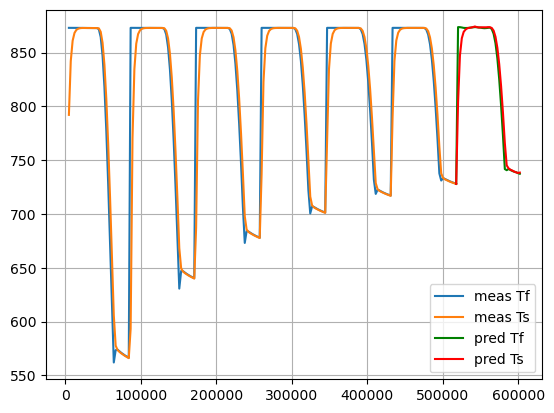

######### Epoch: 2150  ######### Train Loss: 4.262943178900969e-07


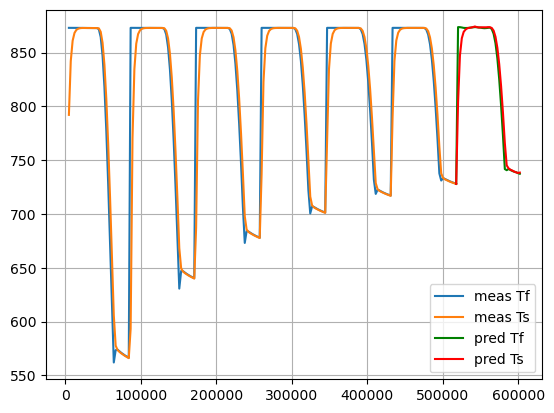

######### Epoch: 2200  ######### Train Loss: 4.262943178900969e-07


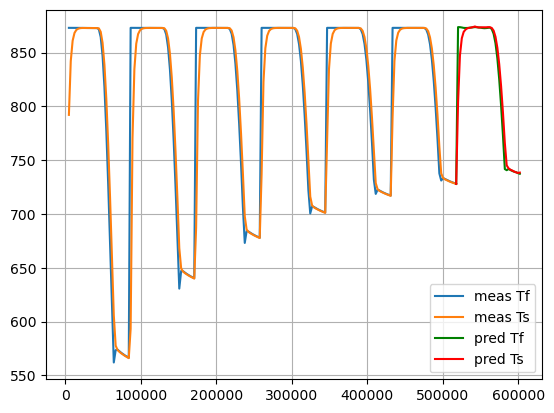

######### Epoch: 2250  ######### Train Loss: 4.262943178900969e-07


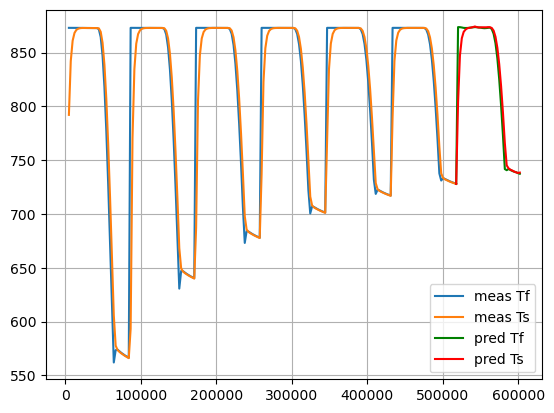

######### Epoch: 2300  ######### Train Loss: 4.262943178900969e-07


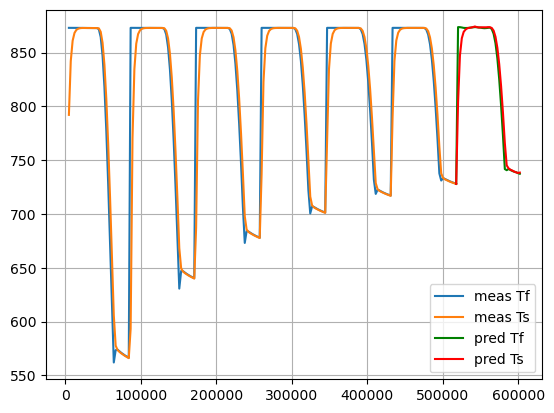

######### Epoch: 2350  ######### Train Loss: 4.262943178900969e-07


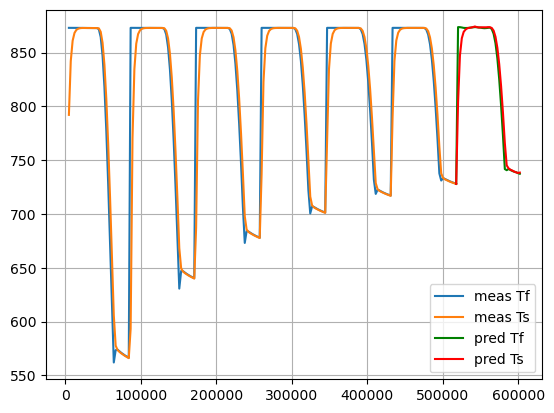

######### Epoch: 2400  ######### Train Loss: 4.262943178900969e-07


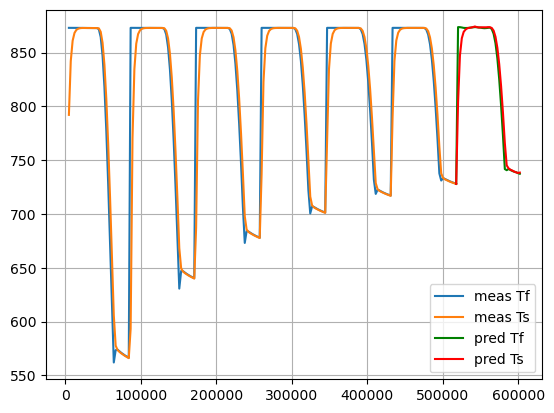

######### Epoch: 2450  ######### Train Loss: 4.262943178900969e-07


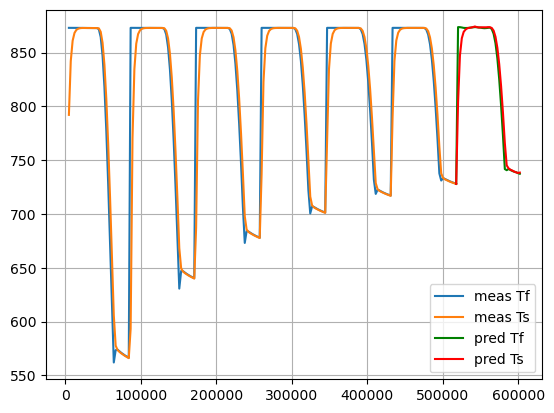

######### Epoch: 2500  ######### Train Loss: 4.262943178900969e-07


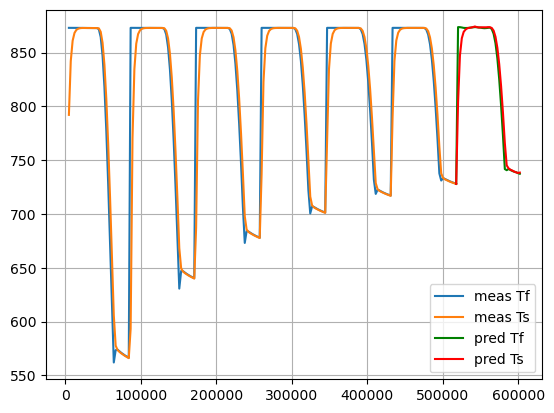

######### Epoch: 2550  ######### Train Loss: 4.262943178900969e-07


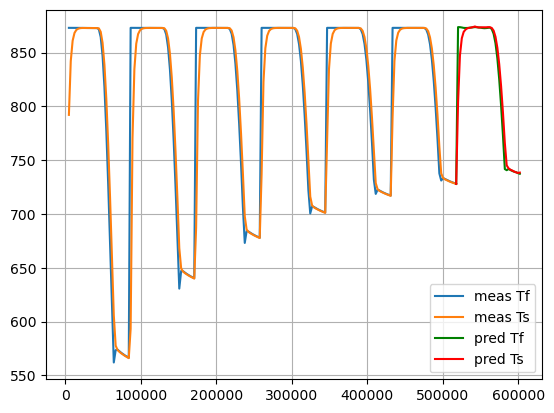

######### Epoch: 2600  ######### Train Loss: 4.262943178900969e-07


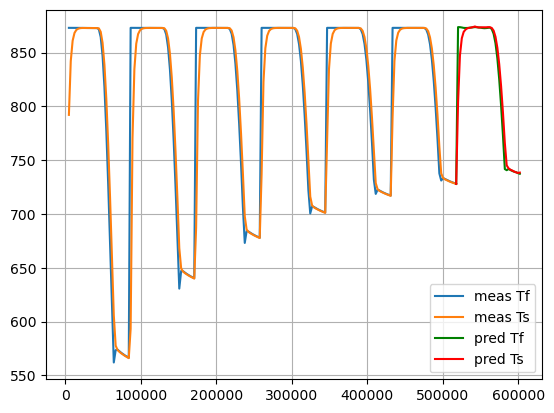

######### Epoch: 2650  ######### Train Loss: 4.262943178900969e-07


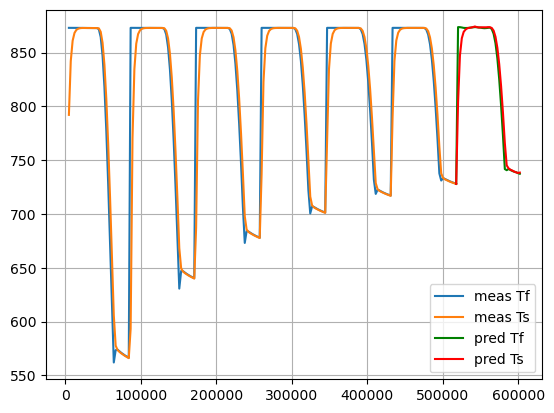

######### Epoch: 2700  ######### Train Loss: 4.262943178900969e-07


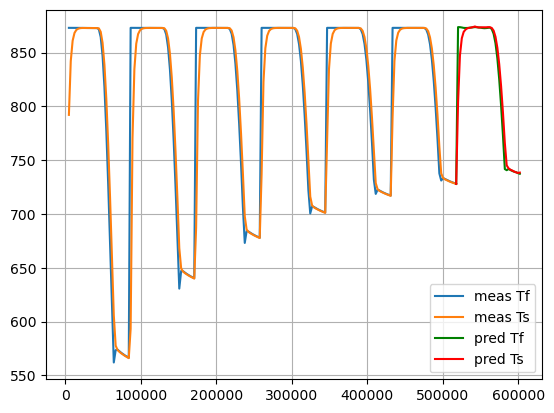

######### Epoch: 2750  ######### Train Loss: 4.262943178900969e-07


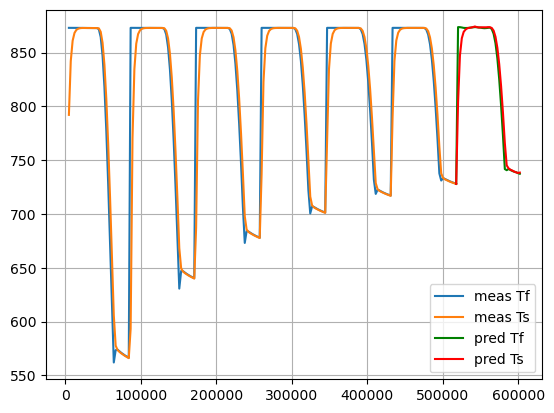

######### Epoch: 2800  ######### Train Loss: 4.262943178900969e-07


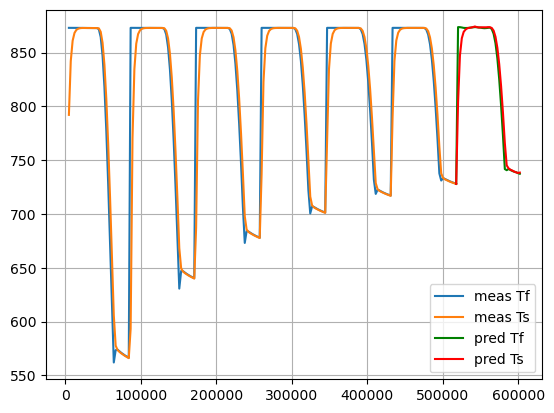

######### Epoch: 2850  ######### Train Loss: 4.262943178900969e-07


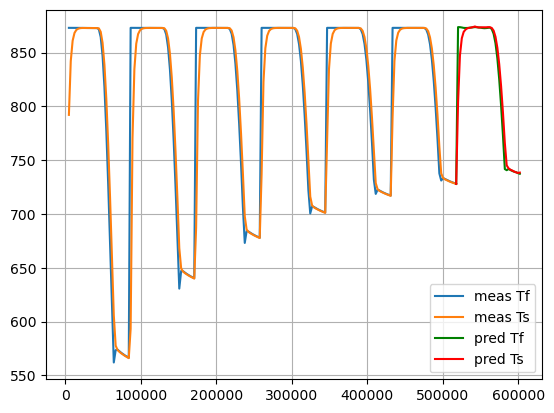

######### Epoch: 2900  ######### Train Loss: 4.262943178900969e-07


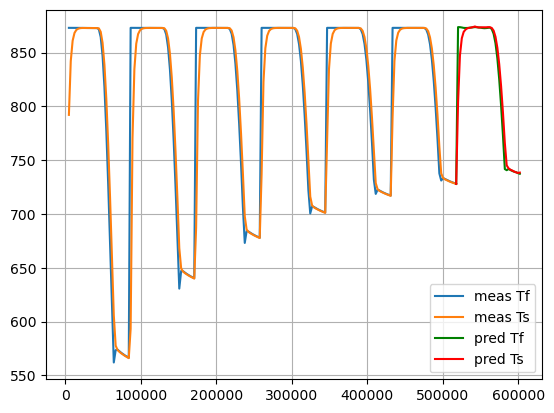

######### Epoch: 2950  ######### Train Loss: 4.262943178900969e-07


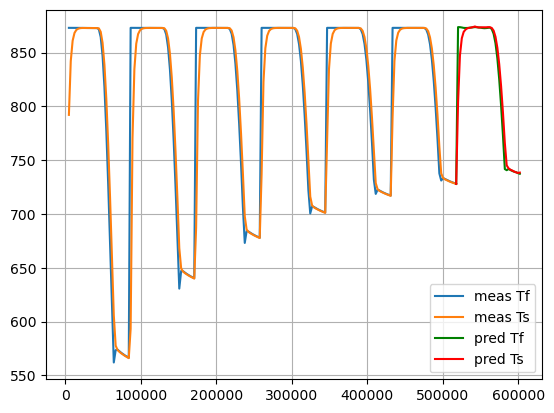

######### Epoch: 3000  ######### Train Loss: 4.262943178900969e-07


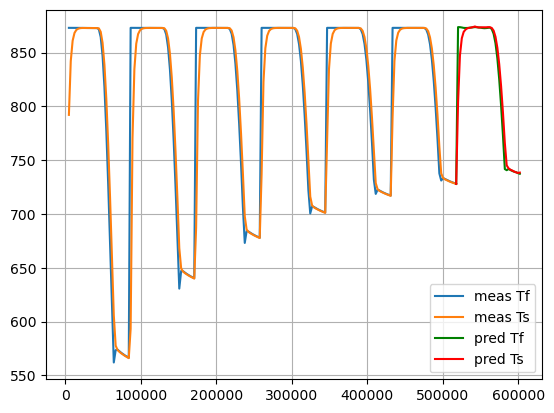

######### Epoch: 3050  ######### Train Loss: 4.262943178900969e-07


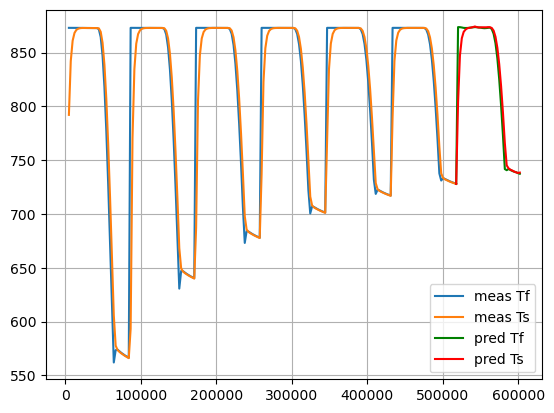

######### Epoch: 3100  ######### Train Loss: 4.262943178900969e-07


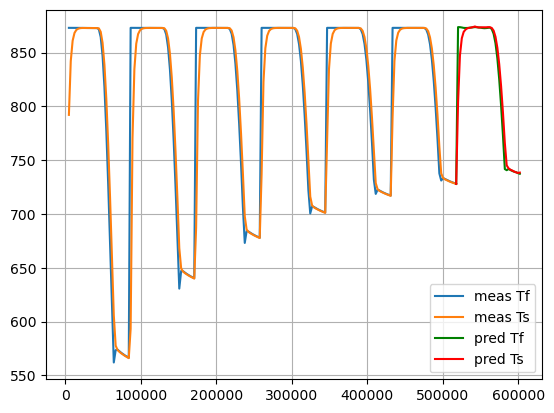

######### Epoch: 3150  ######### Train Loss: 4.262943178900969e-07


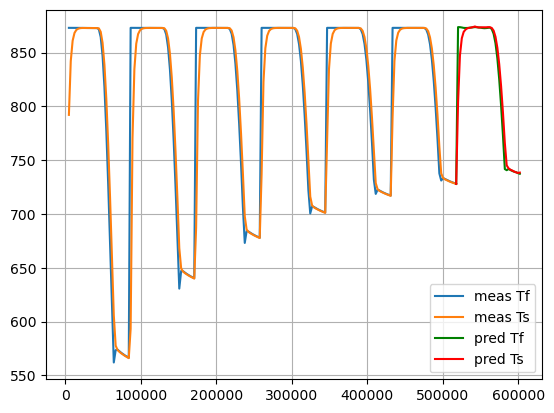

######### Epoch: 3200  ######### Train Loss: 4.262943178900969e-07


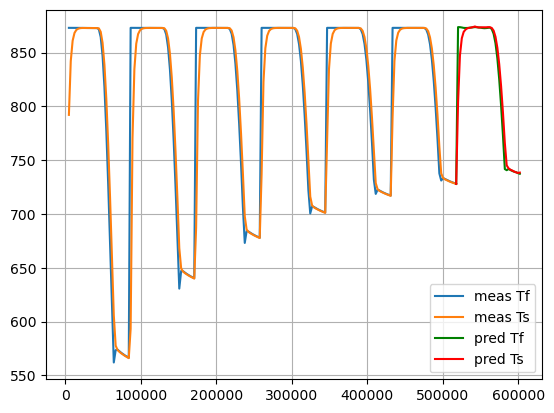

######### Epoch: 3250  ######### Train Loss: 4.262943178900969e-07


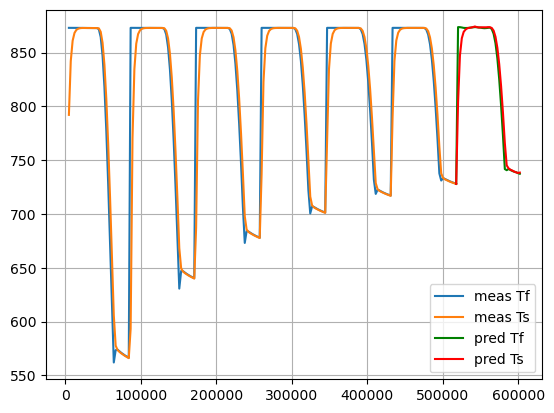

######### Epoch: 3300  ######### Train Loss: 4.262943178900969e-07


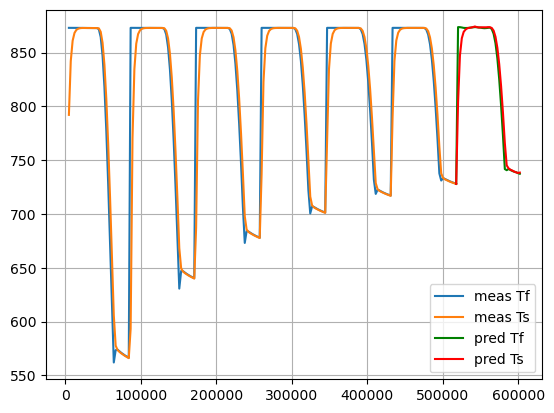

######### Epoch: 3350  ######### Train Loss: 4.262943178900969e-07


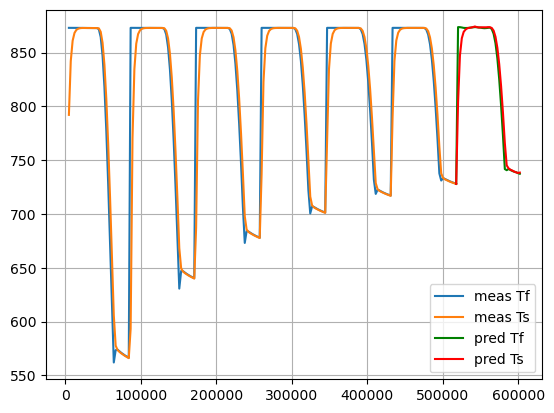

######### Epoch: 3400  ######### Train Loss: 4.262943178900969e-07


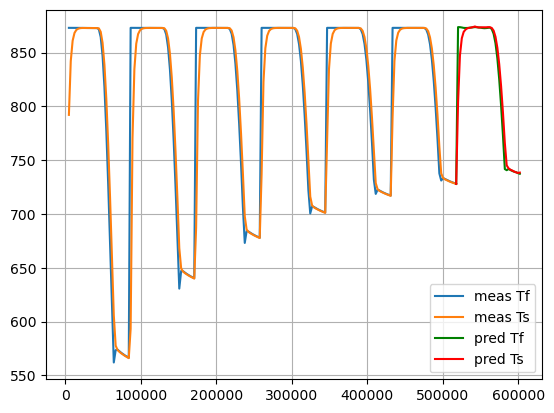

######### Epoch: 3450  ######### Train Loss: 4.262943178900969e-07


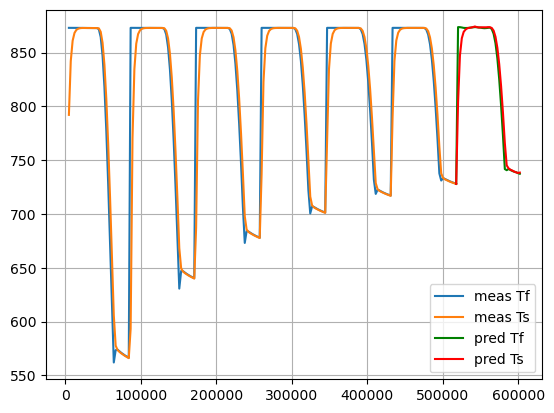

######### Epoch: 3500  ######### Train Loss: 4.262943178900969e-07


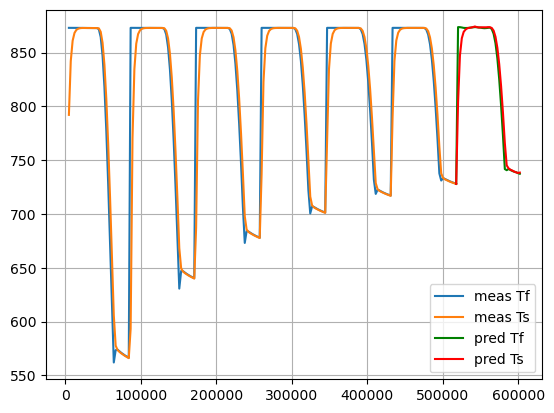

######### Epoch: 3550  ######### Train Loss: 4.262943178900969e-07


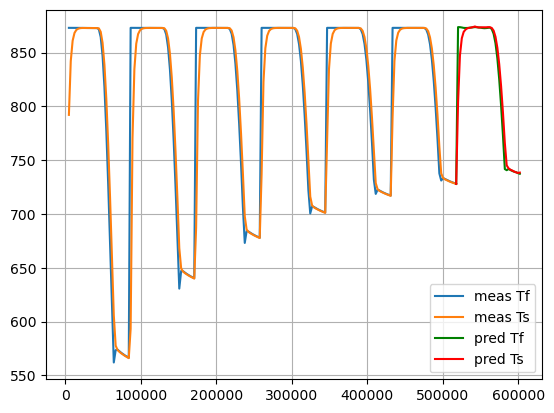

######### Epoch: 3600  ######### Train Loss: 4.262943178900969e-07


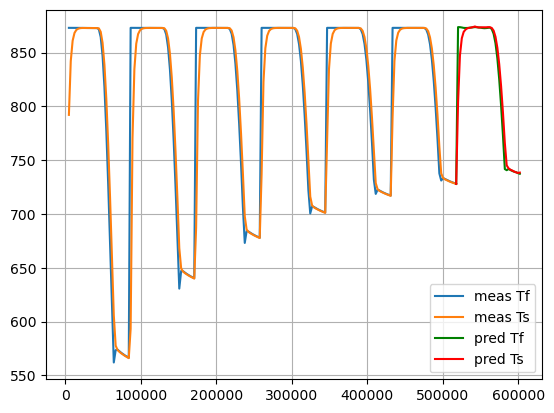

######### Epoch: 3650  ######### Train Loss: 4.262943178900969e-07


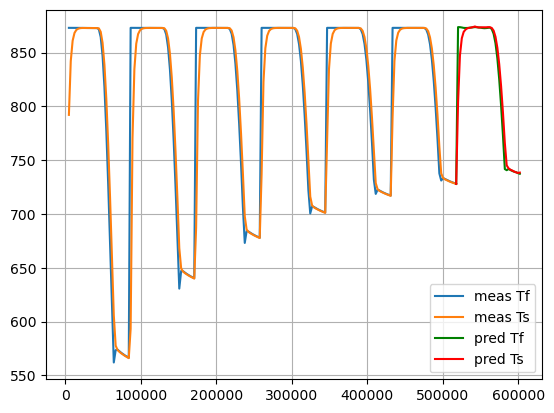

######### Epoch: 3700  ######### Train Loss: 4.262943178900969e-07


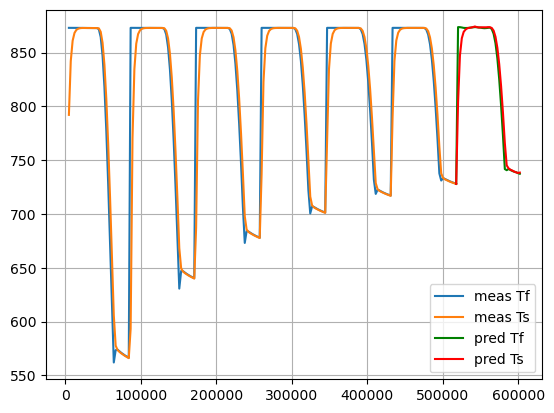

######### Epoch: 3750  ######### Train Loss: 4.262943178900969e-07


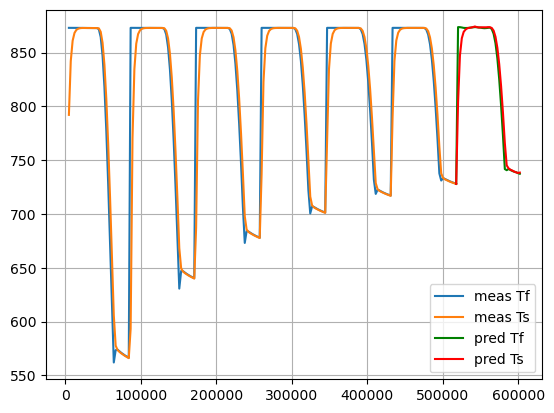

######### Epoch: 3800  ######### Train Loss: 4.262943178900969e-07


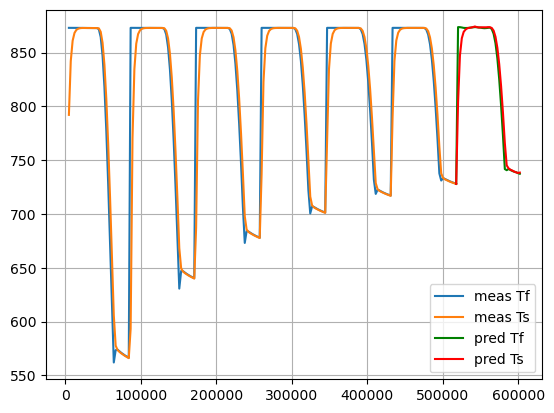

######### Epoch: 3850  ######### Train Loss: 4.262943178900969e-07


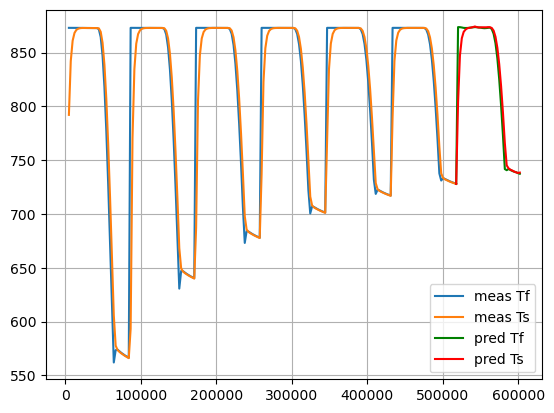

######### Epoch: 3900  ######### Train Loss: 4.262943178900969e-07


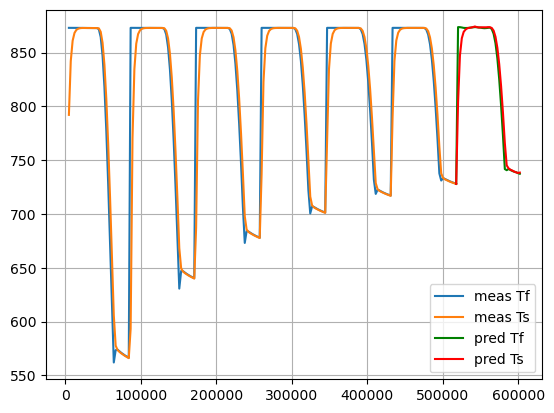

######### Epoch: 3950  ######### Train Loss: 4.262943178900969e-07


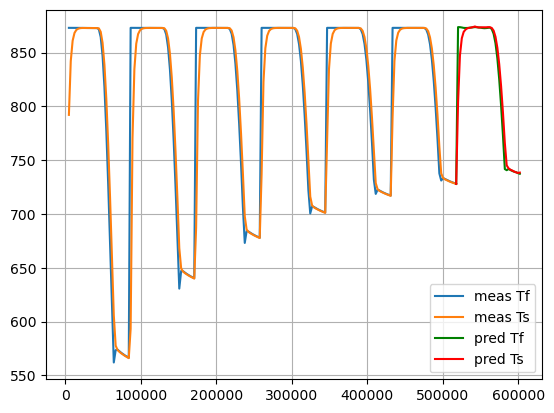

In [107]:
df = pd.read_csv('TrainingData.txt')
train_data = torch.tensor(df[['t','tf0', 'ts0']].values, dtype=torch.float)
train_data, mins, maxs = normalize(train_data)

window_len = 35
batch_size = 1

epochs = 4000
shuffle= False
batch_size=1
freq_print = 50

dataset = DatasetTask3(train_data, window_len)
training_set= torch.utils.data.DataLoader(dataset,batch_size=batch_size, shuffle=shuffle)

learning_rate = 0.001
modes = 18  # we do not truncate the fourier series, rDFT of vec 35 has length 18
width = 256 

fno_f = FNO1d(modes, width)
fno_s = FNO1d(modes, width)

step_size = 50
gamma = 0.5

df = pd.read_csv('TestingData.txt')
test_time_np = df['t'].to_numpy()
test_time = torch.tensor(df['t'].values, dtype=torch.float)

optimizer_Adam = Adam(list(fno_f.parameters()) + list(fno_s.parameters()) , lr=learning_rate, weight_decay= 0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_Adam, step_size=step_size, gamma=gamma)

fit(fno_f, fno_s, epochs,optimizer_Adam, training_set) 
#plot_hist(hist)


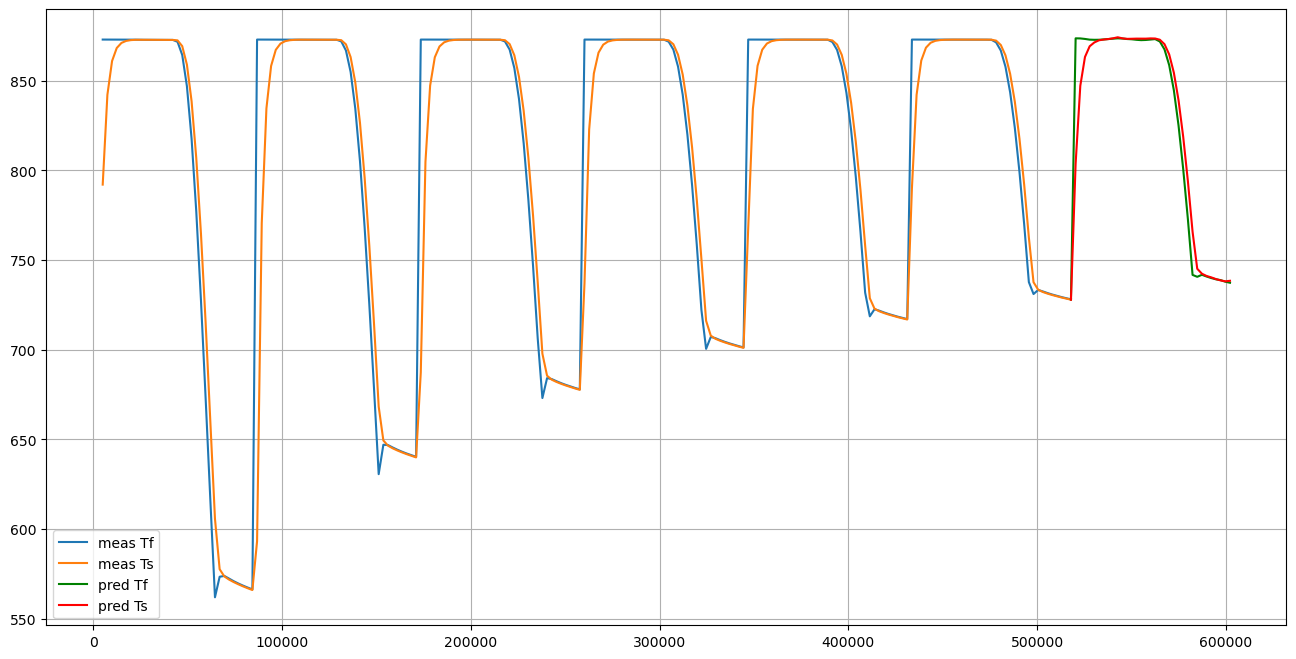

In [117]:
test_set = train_data[-window_len:,:].reshape(1,window_len,3)
output = torch.cat([fno_f(test_set), fno_s(test_set)],dim=2).squeeze()

input_meas = denormalize(train_data, mins, maxs)
output[:,0] = (maxs[1]-mins[1])* output[:,0] + mins[1]
output[:,1] = (maxs[2]-mins[2])* output[:,1] + mins[2]


total_time = torch.cat([input_meas[:,0], test_time], 0)
total_pred = torch.cat([input_meas[:,1:], output[:-1]], 0)


plt.figure(figsize=(16,8))
plt.plot(input_meas[2:,0].detach(), input_meas[2:,1].detach(),label='meas Tf')
plt.plot(input_meas[2:,0].detach(), input_meas[2:,2].detach(),label='meas Ts')
plt.plot(total_time[-window_len:].detach(), total_pred[-window_len:,0].detach(), label = 'pred Tf',color='green')
plt.plot(total_time[-window_len:].detach(), total_pred[-window_len:,1].detach(), label = 'pred Ts',color='red')
plt.grid('True')
plt.legend()
plt.savefig(f'Data/task3_2fno_epochs_{epochs}_width_{width}_shuffle_{shuffle}.png')
plt.show()

In [118]:
test_df = pd.DataFrame({'t': test_time_np, 'tf0': output[:-1,0].detach().numpy(), 'ts0': output[:-1,1].detach().numpy()})
test_df.to_csv(f'Data/task3_2fno_epochs_{epochs}_width_{width}_shuffle_{shuffle}.txt', index=False)